Setting up image transformations...
Loading data...
Found existing split dataset. Loading splits...
Data loaders are ready.
Data loaded. Classes: ['aphid', 'army_worm', 'black_rust', 'brown_rust', 'common_rust', 'fusarium_head_blight', 'healthy', 'leaf_blight', 'powdery_mildew_leaf', 'spetoria', 'tan_spot', 'yellow_rust']
Initializing hybrid model...
Using device: cpu
Model parameters: 32,557,208
Starting training...
Starting training...
Epoch 1, Batch 0/158, Loss: 2.6635
Epoch 1, Batch 10/158, Loss: 2.3860
Epoch 1, Batch 20/158, Loss: 1.8515
Epoch 1, Batch 30/158, Loss: 1.6056
Epoch 1, Batch 40/158, Loss: 1.7866
Epoch 1, Batch 50/158, Loss: 1.2603
Epoch 1, Batch 60/158, Loss: 1.3898
Epoch 1, Batch 70/158, Loss: 0.9050
Epoch 1, Batch 80/158, Loss: 0.9901
Epoch 1, Batch 90/158, Loss: 0.6924
Epoch 1, Batch 100/158, Loss: 0.7084
Epoch 1, Batch 110/158, Loss: 0.9059
Epoch 1, Batch 120/158, Loss: 1.2630
Epoch 1, Batch 130/158, Loss: 1.4560
Epoch 1, Batch 140/158, Loss: 0.4535
Epoch 1, Batch

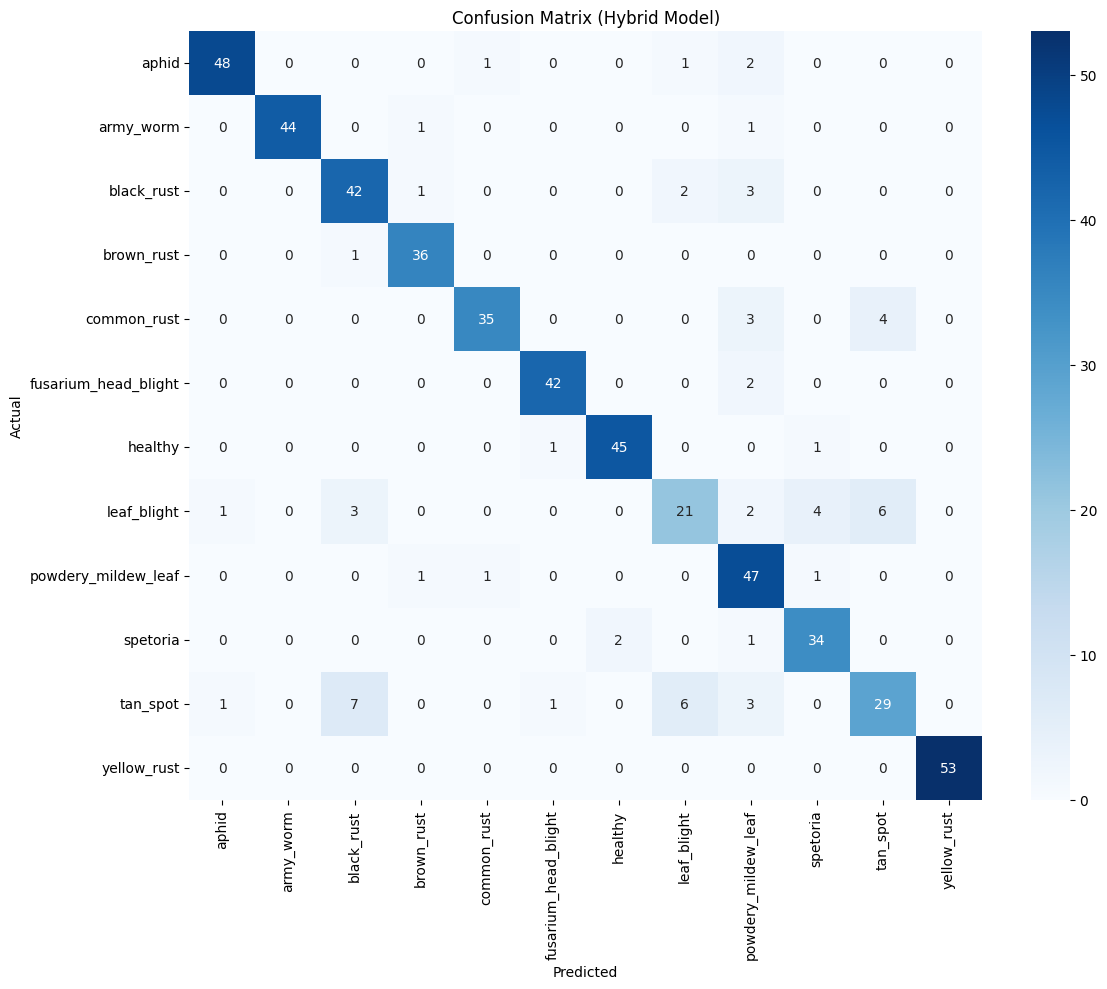


Classification Report:
                      precision    recall  f1-score   support

               aphid     0.9600    0.9231    0.9412        52
           army_worm     1.0000    0.9565    0.9778        46
          black_rust     0.7925    0.8750    0.8317        48
          brown_rust     0.9231    0.9730    0.9474        37
         common_rust     0.9459    0.8333    0.8861        42
fusarium_head_blight     0.9545    0.9545    0.9545        44
             healthy     0.9574    0.9574    0.9574        47
         leaf_blight     0.7000    0.5676    0.6269        37
 powdery_mildew_leaf     0.7344    0.9400    0.8246        50
            spetoria     0.8500    0.9189    0.8831        37
            tan_spot     0.7436    0.6170    0.6744        47
         yellow_rust     1.0000    1.0000    1.0000        53

            accuracy                         0.8815       540
           macro avg     0.8801    0.8764    0.8754       540
        weighted avg     0.8831    0.8815   

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
import time
import cv2
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Configuration
# -----------------------------
DATASET_DIR = '../dataset'
SAVE_DIR = '../saved_models_and_data'
SPLIT_OUTPUT_DIR = '../dataset_split'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced due to memory requirements
TEST_SIZE = 0.15
VAL_SIZE = 0.15
EPOCHS = 10

LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
USE_MIXED_PRECISION = True if torch.cuda.is_available() else False

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SPLIT_OUTPUT_DIR, exist_ok=True)

# -----------------------------
# Preprocessing Functions
# -----------------------------
def canny_edge_detection(img: np.ndarray) -> np.ndarray:
    """Apply Canny edge detection"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    return cv2.Canny(gray, 100, 200)

def gaussian_blur_filter(img: np.ndarray) -> np.ndarray:
    """Apply Gaussian blur"""
    return cv2.GaussianBlur(img, (5, 5), 0)

def laplace_filter(img: np.ndarray) -> np.ndarray:
    """Apply Laplacian filter"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return np.uint8(np.absolute(laplacian))

def high_pass_filter(img: np.ndarray) -> np.ndarray:
    """Apply high-pass filter using FFT"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Apply FFT
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    
    # Create high-pass filter
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    r = 30  # Radius for high-pass filter
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 0
    
    # Apply mask
    f_shift_filtered = f_shift * mask
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    # Normalize
    img_back = ((img_back - img_back.min()) / (img_back.max() - img_back.min()) * 255).astype(np.uint8)
    return img_back

def apply_preprocessing(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Apply all preprocessing techniques"""
    # Convert PIL to numpy if needed
    if isinstance(img, Image.Image):
        img = np.array(img)
    
    # Apply preprocessing techniques
    canny = canny_edge_detection(img)
    gaussian = gaussian_blur_filter(img)
    laplace = laplace_filter(img)
    hpf = high_pass_filter(img)
    
    return canny, gaussian, laplace, hpf

# -----------------------------
# Simplified Hybrid Model
# -----------------------------
class HybridModel(nn.Module):
    """Simplified Hybrid Model using pre-trained models"""
    def __init__(self, num_classes=12):
        super().__init__()
        
        # Use pre-trained models for better performance
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layers
        self.resnet_features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.efficientnet_features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        
        # Fusion layer
        resnet_features = 2048  # ResNet50 features
        efficientnet_features = 1280  # EfficientNet-B0 features
        fusion_dim = 512
        
        self.fusion = nn.Sequential(
            nn.Linear(resnet_features + efficientnet_features, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final classifier
        self.classifier = nn.Linear(fusion_dim, num_classes)
        
    def forward(self, x):
        # Extract features from both models
        resnet_features = self.resnet_features(x).flatten(1)
        efficientnet_features = self.efficientnet_features(x).flatten(1)
        
        # Fusion
        combined_features = torch.cat([resnet_features, efficientnet_features], dim=1)
        fused_features = self.fusion(combined_features)
        
        # Classification
        output = self.classifier(fused_features)
        return output

# -----------------------------
# Custom Dataset with Preprocessing
# -----------------------------
class WheatDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None, apply_preprocessing=False):
        self.root_dir = root_dir
        self.transform = transform
        self.apply_preprocessing = apply_preprocessing
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        
        for target_class in self.classes:
            class_dir = os.path.join(root_dir, target_class)
            for img_file in os.listdir(class_dir):
                path = os.path.join(class_dir, img_file)
                self.samples.append((path, self.class_to_idx[target_class]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            image = Image.open(path).convert("RGB")
            
            if self.transform:
                image = self.transform(image)
            
            return image, target
            
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

# -----------------------------
# Data Loading and Splitting
# -----------------------------
def get_data_loaders():
    # Check if split exists
    split_dirs = [os.path.join(SPLIT_OUTPUT_DIR, split) for split in ['train', 'val', 'test']]
    split_exists = all(os.path.isdir(d) and len(os.listdir(d)) > 0 for d in split_dirs)
    
    if split_exists:
        print('Found existing split dataset. Loading splits...')
        train_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'train'), 
            transform=train_transform, 
            apply_preprocessing=False
        )
        val_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'val'), 
            transform=test_transform, 
            apply_preprocessing=False
        )
        test_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'test'), 
            transform=test_transform, 
            apply_preprocessing=False
        )
    else:
        print('No split dataset found. Splitting and saving images...')
        full_dataset = WheatDiseaseDataset(DATASET_DIR, transform=None, apply_preprocessing=False)
        generator = torch.Generator().manual_seed(42)
        indices = torch.randperm(len(full_dataset), generator=generator).tolist()
        
        train_size = int((1 - TEST_SIZE - VAL_SIZE) * len(full_dataset))
        val_size = int(VAL_SIZE * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]
        
        train_data = Subset(full_dataset, train_indices)
        val_data = Subset(full_dataset, val_indices)
        test_data = Subset(full_dataset, test_indices)
        
        def save_split_images(dataset, indices, split_name):
            print(f"Saving images for split: {split_name}")
            for idx in indices:
                path, label_idx = dataset.dataset.samples[idx]
                class_name = dataset.dataset.classes[label_idx]
                filename = os.path.basename(path)
                dest_dir = os.path.join(SPLIT_OUTPUT_DIR, split_name, class_name)
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, filename)
                shutil.copyfile(path, dest_path)
        
        save_split_images(train_data, train_indices, 'train')
        save_split_images(val_data, val_indices, 'val')
        save_split_images(test_data, test_indices, 'test')
        print('Image splits saved.')
        
        train_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'train'), 
            transform=train_transform, 
            apply_preprocessing=False
        )
        val_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'val'), 
            transform=test_transform, 
            apply_preprocessing=False
        )
        test_dataset = WheatDiseaseDataset(
            os.path.join(SPLIT_OUTPUT_DIR, 'test'), 
            transform=test_transform, 
            apply_preprocessing=False
        )
    
    # Calculate class weights for balanced sampling
    targets = [s[1] for s in train_dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print('Data loaders are ready.')
    return train_loader, val_loader, test_loader, train_dataset.classes

# -----------------------------
# Training Function
# -----------------------------
def train_model(model, device, train_loader, val_loader, num_epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_acc = 0.0
    no_improvement_epochs = 0
    scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    train_log = []
    
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
    
    print("Starting training...")
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.6f} | "
              f"Time: {time.time()-start_time:.1f}s")
        
        train_log.append({
            'epoch': epoch+1, 
            'train_loss': epoch_loss, 
            'train_acc': epoch_acc.item(), 
            'val_loss': val_loss, 
            'val_acc': val_acc.item(), 
            'lr': current_lr
        })
        
        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_hybrid_model.pth"))
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
        
        if no_improvement_epochs >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break
    
    print("Training completed.")
    return model, train_log

# -----------------------------
# Main Execution
# -----------------------------
def main():
    print("Setting up image transformations...")
    global train_transform, test_transform
    
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    print('Loading data...')
    train_loader, val_loader, test_loader, class_labels = get_data_loaders()
    print('Data loaded. Classes:', class_labels)
    
    print('Initializing hybrid model...')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = HybridModel(num_classes=len(class_labels)).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    print('Starting training...')
    model, train_log = train_model(model, device, train_loader, val_loader)
    
    print('Training complete. Evaluating on test set...')
    # Load best model
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_hybrid_model.pth"), map_location=device))
    model.eval()
    
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    print('Test set predictions complete. Generating confusion matrix...')
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Hybrid Model)")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "hybrid_model_confusion_matrix.png"))
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, "wheat_disease_hybrid_model.pth"))
    print('Model saved to', os.path.join(SAVE_DIR, "wheat_disease_hybrid_model.pth"))
    
    # Save training log
    import json
    with open(os.path.join(SAVE_DIR, "hybrid_model_training_log.json"), 'w') as f:
        json.dump(train_log, f, indent=2)
    print('Training log saved.')

if __name__ == "__main__":
    main() 